In [ ]:
!pip install tree-sitter-python tree-sitter autopep8 sentence_transformers

In [2]:
%cd ..
import os
os.getcwd()

/Users/macbook/Library/CloudStorage/GoogleDrive-nguyenminhloc2905@gmail.com/My Drive/Code/llm4ad


'/Users/macbook/Library/CloudStorage/GoogleDrive-nguyenminhloc2905@gmail.com/My Drive/Code/llm4ad'

# Diversity analysis

In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, euclidean
from scipy.sparse.csgraph import minimum_spanning_tree
from math import log

# Define a function to get embeddings
def get_embedding(code: str, model, tokenizer, device):
    '''
    Args:
        Returns the embedding vector from a code string
    '''
    inputs = tokenizer.encode(code, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model(inputs)[0].cpu().numpy() #(vector_dim, )
    return embedding.reshape(1, -1) # (1, vector_dim)


def compute_cosine_similarity(embeddings): # n_samples x vector_dim
    return cosine_similarity(embeddings) # n_samples x n_samples metrics
# [[1.        0.82...]   # 1.0 with itself, 0.82 similarity with the other
#  [0.82...   1.       ]]


def cluster_nodes(similarity_matrix, threshold=0.95):
    '''
    Args:
        n_samples x n_samples
        threshold: how similar items need to be to be in the same cluster
        This builds a dictionary where:
        Key = cluster ID
        Value = list of node indices in that cluster.
    '''
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    distance_matrix = np.clip(distance_matrix, 0, None) # if negative in a cell, it is 0

    # Use hierarchical clustering
    condensed_distance_matrix = squareform(distance_matrix)
    Z = linkage(condensed_distance_matrix, method='complete')

    clusters = fcluster(Z, t=1-threshold, criterion='distance')

    # Collect nodes into clusters
    node_clusters = {}
    for node, cluster_id in enumerate(clusters):
        if cluster_id not in node_clusters:
            node_clusters[cluster_id] = []
        node_clusters[cluster_id].append(node)

    return list(node_clusters.values())


def calculate_shannon_diversity(clusters, total_nodes):
    proportions = [len(cluster) / total_nodes for cluster in clusters]
    shannon_index = -sum(p * log(p) for p in proportions if p > 0)
    return shannon_index


def shannon_diversity(embeddings, threshold):
    embeddings_2d = np.vstack(embeddings)

    # Compute similarity matrix
    similarity_matrix = compute_cosine_similarity(embeddings_2d)
    np.fill_diagonal(similarity_matrix, 1)
    #print(similarity_matrix)

    # Cluster nodes with a similarity threshold
    clusters = cluster_nodes(similarity_matrix, threshold)

    # Calculate Shannon Diversity Index
    total_nodes = len(embeddings)
    shannon_diversity_index = calculate_shannon_diversity(clusters, total_nodes)

    print("Clusters:", clusters)
    print("Shannon Diversity Index:", shannon_diversity_index)
    return shannon_diversity_index


def total_diversity(embeddings):
    embeddings_1d = np.vstack([emb.flatten() for emb in embeddings])  # Ensure 1D embeddings

    # Compute the distance matrix
    n = len(embeddings_1d)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance = euclidean(embeddings_1d[i], embeddings_1d[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # Find the Minimum Spanning Tree (MST)
    mst = minimum_spanning_tree(distance_matrix).toarray()

    # Calculate the diversity index
    mst_distances = mst[mst != 0]
    total_distance = np.sum(mst_distances)

    proportions = mst_distances / total_distance
    diversity_index = -np.sum(proportions * np.log(proportions))

    print(f"CDI: {diversity_index}")
    return diversity_index

# Model and tokenizer setup
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cpu"  # Use "cuda" if you have a GPU
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

def get_static(code_snippets: list[str], threshold):
    '''
    Args:
        code_snippets: list of string code
        threshold = 0.95 means the number for 2 code to be in the same cluster
    '''
    # Get embeddings for all code snippets
    embeddings = [get_embedding(code, model, tokenizer, device) for code in code_snippets]

    shannon_diversity_index = shannon_diversity(embeddings, threshold=threshold)
    CID = total_diversity(embeddings)
    return shannon_diversity_index, CID


/Users/macbook/miniconda3/envs/eoh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import json
def read_code_snippets(json_path: str):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    code_snippets = [i["function"] for i in data]
    return code_snippets

code_snippets = read_code_snippets("logs/meoh/200_samples_v1/samples/samples_1~200.json")

# for code_section in code_snippets
# shannon, cid = get_static(code_snippets, threshold=0.95)
# print(shannon, cid)

Token indices sequence length is longer than the specified maximum sequence length for this model (854 > 512). Running this sequence through the model will result in indexing errors


Clusters: [[0, 4, 11, 24, 26, 27, 28, 29, 32, 37, 39, 41, 43, 47, 50, 54, 60, 62, 63, 64, 67, 75, 76, 82, 83, 84, 85, 87, 90, 91, 96, 98, 103, 108, 113, 114, 116, 117, 124, 125, 128, 133, 137, 141, 144, 149, 154, 155, 156, 164, 169, 177, 178, 192], [1, 3, 5, 7, 8, 10, 12, 13, 15, 19, 20, 35, 36, 44, 53, 61, 71, 73, 88, 89, 92, 99, 101, 104, 105, 112, 118, 119, 132, 135, 142, 145, 147, 150, 151, 157, 161, 168, 170, 173, 176, 180, 188, 190, 191, 193], [2, 9, 14, 16, 21, 22, 23, 25, 30, 31, 33, 34, 38, 40, 42, 45, 46, 48, 49, 51, 52, 55, 56, 57, 58, 59, 65, 66, 68, 69, 70, 72, 74, 77, 78, 79, 80, 81, 86, 93, 94, 95, 97, 100, 102, 106, 107, 109, 110, 115, 120, 121, 122, 123, 126, 127, 129, 130, 131, 134, 136, 138, 139, 140, 143, 146, 148, 152, 153, 158, 160, 162, 165, 166, 167, 171, 172, 174, 175, 179, 181, 182, 183, 184, 185, 186, 187, 189, 194, 195, 196, 197], [6, 18, 111, 159, 163], [17]]
Shannon Diversity Index: 1.1692044983528616
CDI: 5.2168868845514496
1.1692044983528616 5.2168868845

In [5]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
def build_code_pareto_front(json_path: str):
    full_scores = []

    with open(json_path, "r") as f:
        data = json.load(f)
    
    code_snippets = [i["function"] for i in data]
    scores = [item.get("score") for item in data if item.get("score") is not None]
    scores = [[abs(x) for x in pair] for pair in scores]
    full_scores.extend(scores)
    full_scores = np.array(full_scores)
    target_evals = sorted(set(range(10, len(full_scores), 10)) | {len(full_scores)})

    P_front_each_iteration = []
    code_front = []
    for target in target_evals:
        so_far = full_scores[:target+1]
        code_snippets_so_far = code_snippets[:target+1]
        
        nd_idx = NonDominatedSorting().do(so_far, only_non_dominated_front=True) # get pareto front of heuristics at evaluation target
        print(f"Nd is: {nd_idx}")
        P = so_far[nd_idx]
        codes = [code_snippets_so_far[i] for i in nd_idx]
        P_front_each_iteration.append(P)
        code_front.append(codes)
    return code_front


Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors


Nd is: [ 2  7  8 10]
Nd is: [ 2  7  8 10]
Nd is: [ 2  7  8 10 21]
Nd is: [ 2  7  8 10 21 33 39]
Nd is: [ 2  7  8 10 21 33 39]
Nd is: [ 2  7  8 10 21 33 39 51 54]
Nd is: [ 2 10 21 33 39 51 54 66 68]
Nd is: [ 2 10 21 33 39 51 54 66 68]
Nd is: [ 2 10 21 33 39 51 54 66 68]
Nd is: [ 2 10 21 33 39 51 54 66 68]
Nd is: [  2  10  39  51  66  68 101]
Nd is: [  2  10  39  51  66  68 101]
Nd is: [  2  10  39  66  68 101 124]
Nd is: [  2  10  39  66  68 101 124]
Nd is: [  2  10  39  66  68 101 124]
Clusters: [[0], [1, 2, 3]]
Shannon Diversity Index: 0.5623351446188083
CDI: 1.0632942862794366
Clusters: [[0], [1, 2, 3]]
Shannon Diversity Index: 0.5623351446188083
CDI: 1.0632942862794366
Clusters: [[0], [1, 2, 3, 4]]
Shannon Diversity Index: 0.5004024235381879
CDI: 1.3569390293509522
Clusters: [[0], [1, 2, 3, 4, 5, 6]]
Shannon Diversity Index: 0.410116318288409
CDI: 1.769884484573204
Clusters: [[0], [1, 2, 3, 4, 5, 6]]
Shannon Diversity Index: 0.410116318288409
CDI: 1.769884484573204
Clusters: [[0], [

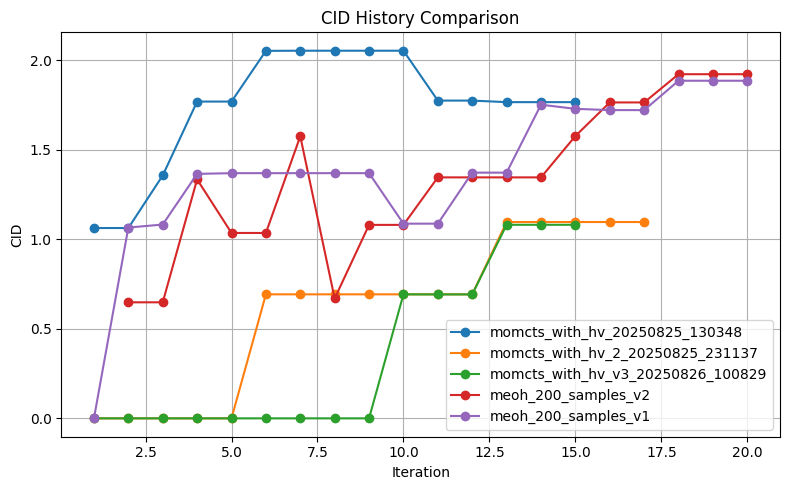

In [6]:
import matplotlib.pyplot as plt
import json
def plot_cid_history_multiple(json_paths, threshold=0.95):
    plt.figure(figsize=(8, 5))

    for path in json_paths:
        code_snippets_iteration = build_code_pareto_front(path)
        cid_history = []

        for code in code_snippets_iteration:
            try:
                _, cid = get_static(code, threshold=threshold)
                cid_history.append(cid)
            except ValueError:
                # Skip if empty embeddings or calculation fails
                cid_history.append(np.nan)

        label_name = f"{path.split('/')[-4]}_{path.split('/')[-3]}"
        plt.plot(range(1, len(cid_history) + 1), cid_history, marker='o', linestyle='-', label=label_name)

    plt.xlabel("Iteration")
    plt.ylabel("CID")
    plt.title("CID History Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    paths = [
        "logs/momcts/momcts_with_hv/20250825_130348/samples/samples_1~200.json",
        "logs/momcts/momcts_with_hv_2/20250825_231137/samples/samples_1~200.json",
        "logs/momcts/momcts_with_hv_v3/20250826_100829/samples/samples_1~200.json",
        "logs/meoh/200_samples_v2/samples/samples_1~200.json",
        "logs/meoh/200_samples_v1/samples/samples_1~200.json"
    ]
    plot_cid_history_multiple(paths)


# Pre-process Log Data

##  Population encoding

In [ ]:
import os
import autopep8
import tempfile
import json
import re

import tree_sitter_python as tspython
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
parser = Parser(PY_LANGUAGE)

def format_python_code(code_str):
    # Write the code string to a temporary file
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.py') as temp_file:
        temp_file.write(code_str)
        temp_filename = temp_file.name

    # Format the file using autopep8
    autopep8_args = ['--in-place', '--aggressive', '--aggressive', temp_filename]
    autopep8.fix_file(temp_filename, options=autopep8.parse_args(autopep8_args))

    # Read the formatted code from the file
    with open(temp_filename, 'r') as temp_file:
        formatted_code = temp_file.read()

    return formatted_code

def remove_comments_and_docstrings(code):
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    lines = code.split('\n')
    to_remove = []

    def is_comment(node):
        return node.type == 'comment'

    def is_docstring(node):
        return (node.type == 'string' and
                (node.parent.type in ['expression_statement', 'module']))

    def traverse(node):
        if is_comment(node):
            to_remove.append((node.start_point, node.end_point))
        elif is_docstring(node):
            to_remove.append((node.start_point, node.end_point))
        for child in node.children:
            traverse(child)

    traverse(root_node)

    for start, end in reversed(to_remove):
        start_row, start_col = start
        end_row, end_col = end
        if start_row == end_row:
            lines[start_row] = lines[start_row][:start_col] + lines[start_row][end_col:]
        else:
            lines[start_row] = lines[start_row][:start_col]
            for row in range(start_row + 1, end_row):
                lines[row] = ''
            lines[end_row] = lines[end_row][end_col:]

    cleaned_lines = [line for line in lines if line.strip() != '']

    return '\n'.join(cleaned_lines)

## Utils function

In [ ]:
def read_all_files_in_folder(folder_path, framework_name, parsed_data):
    if 'funsearch' in framework_name:
        folder_path = os.path.join(folder_path, 'samples')
    files = os.listdir(folder_path)
    lstcode = dict()

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        file_name_without_ext = os.path.splitext(file_name)[0]

        if ('hsevo' in framework_name or 'reevo' in framework_name) and ('_response' in file_name_without_ext or '_hs' in file_name_without_ext) and '_prompt' not in file_name_without_ext and 'objs_log_' not in file_name_without_ext:
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    if '.txt_stdout' not in file_name_without_ext:
                        lstcode[file_name_without_ext] = content.replace('```python', '').replace('```', '')
                    elif '.txt_stdout' in file_name_without_ext and "[*] Average:" not in content:
                        file_name_without_ext = os.path.splitext(file_name_without_ext)[0]
                        lstcode.pop(file_name_without_ext)
                    #print(f'Content of {file_name}:\n{content}\n')
            except Exception as e:
                print(f'Could not read {file_name}: {e}')
        if 'funsearch' in framework_name:
            id_sample = file_name_without_ext.split('_')[1]

            if(int(id_sample) <= 330):
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        content = json.loads(content)
                        if content['score']:
                            lstcode[file_name_without_ext] = content['function']
                            excess = (-content['score'] - l1_bound) / l1_bound * 100
                            parsed_data[int(id_sample)] = parsed_data[int(id_sample)] + (excess,)
                except Exception as e:
                    print(f'Could not read {file_name}: {e}')

    return lstcode

def parse_log(log_string):
  best_obj_pattern = re.compile(r"Best obj: (-?[\d\.]+)")
  tokens_pattern = re.compile(r"prompt_tokens = (\d+), completion_tokens = (\d+)")


  best_objs = best_obj_pattern.findall(log_string)
  tokens_matches = tokens_pattern.findall(log_string)

  results = []
  for i in range(max(len(best_objs), len(tokens_matches))):
      prompt_tokens = int(tokens_matches[i][0])
      completion_tokens = int(tokens_matches[i][1])
      total_tokens = prompt_tokens + completion_tokens
      try:
          best_obj = float(best_objs[i])
      except:
          best_obj = None

      if best_obj is not None:
        results.append((total_tokens, best_obj))
      else:
        results.append((total_tokens, ))

  return results

In [ ]:
def create_sets_from_data(data, group_size=10):
    result = []
    min_second = float('inf')
    for i in range(0, len(data), group_size):
        group = data[i:i+group_size]
        max_first = max(item[0] for item in group)

        # Update the minimum value for the second position, considering all elements from the start to the current group
        for item in data[:i+len(group)]:
            if len(item) > 1:  # Check if there's a second position
                min_second = min(min_second, item[1])
        result.append((max_first, min_second))

    return result

def create_sets_from_data_eoh(parsed_data, num_init, obj_eoh):
    num_gen = len(obj_eoh)
    # Step 1: Group the first `num_init` elements and get the max value of this group
    first_group = max(parsed_data[:num_init])[0]

    # Step 2: Calculate the number of elements in each subsequent group
    remaining_elements = len(parsed_data) - num_init
    group_size = remaining_elements // num_gen

    # Step 3: Initialize the list to store the result
    result = [(first_group, 0)]

    # Step 4: Group the remaining elements and get the max value of each group
    for i in range(num_gen):
        start_index = num_init + i * group_size
        end_index = start_index + group_size
        group = parsed_data[start_index:end_index]
        max_value = max(group)[0]
        result.append((max_value, obj_eoh[i]*100))

    return result

def get_max_obj_eoh(folder_path):
    lst_obj_eoh = []
    folder_path += "/pops_best"
    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                content = json.loads(content)
                lst_obj_eoh.append(content['objective'])
        except Exception as e:
            print(f'Could not read {file_name}: {e}')
    return lst_obj_eoh


def get_init_eoh(folder_path):
    lstcode = dict()
    init_logs = folder_path + "/pops/population_generation_0.json"
    with open(init_logs, 'r', encoding='utf-8') as file:
        content = file.read()
        content = json.loads(content)
        for idx, data in enumerate(content):
            if data['objective']:
                name_idv = "pop_0_off" + str(idx) + "_i0"
                lstcode[name_idv] = data['code']
    return lstcode

def eoh_preprocess(folder_path, parsed_data):
    # List all files in the folder
    lstcode = get_init_eoh(folder_path)

    folder_path += "/history"
    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        file_name_without_ext = os.path.splitext(file_name)[0]

        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                content = json.loads(content)
                if content['offspring']['objective']:
                    lstcode[file_name_without_ext] = content['offspring']['code']
        except Exception as e:
            print(f'Could not read {file_name}: {e}')

    return lstcode

# Diversity calculator

In [ ]:
log_run = {
        "name": "hsevo_1",
        "path": "<path>"
}


f = open(log_run["path"] + '/main.log', "r")
data = f.read().split('\n')
f.close()
raw_string = ''
for idl in range(len(data)):
  if "hsevo" in log_run["name"] or "reevo" in log_run["name"]:
    if 'Best obj:' in data[idl]:
      raw_string += data[idl] + '\n' + data[idl+1] + '\n'
  elif "funsearch" in log_run["name"] or "eoh" in log_run["name"]:
    match = re.search(r"l1_bound:\s*([\d.]+)", data[0])
    if match:
      l1_bound = float(match.group(1))
      raw_string = '\n'.join(data[1:])
    else:
      raw_string = '\n'.join(data)



if "eoh" in log_run["name"]:
    lstcode = eoh_preprocess(log_run["path"], parsed_data)
    lst_init_eoh = get_init_eoh(log_run["path"])
    obj_eoh = get_max_obj_eoh(log_run["path"])
    parsed_data = create_sets_from_data_eoh(parsed_data, len(lst_init_eoh), obj_eoh)
elif "funsearch" in log_run["name"]:
    parsed_data = create_sets_from_data(parsed_data, 20)
else:
    parsed_data = parse_log(raw_string)

lstcode = read_all_files_in_folder(log_run["path"], log_run["name"], parsed_data)
for name, code in lstcode.items():
    # 1. Format code following PEP8
    formatted_code = format_python_code(code)

    # 2. Remove comments and docstrings in code
    cleaned_code = remove_comments_and_docstrings(formatted_code)
    lstcode[name] = cleaned_code

In [ ]:
from collections import defaultdict

def group_names(lstcode, framework_name, base = 20):
    grouped_lists = defaultdict(list)

    # Regular expression patterns
    pattern_hsevo = re.compile(r'problem_iter(\d+)')
    pattern_reevo = re.compile(r'problem_iter(\d+)')
    pattern_funsearch = re.compile(r'samples_(\d+)')
    pattern_eoh = re.compile(r'pop_(\d+)')

    for name in lstcode.keys():
        log_run = lstcode[name]

        if "hsevo" in framework_name:
            match = pattern_reevo.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)
        elif "reevo" in framework_name:
            match = pattern_reevo.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)
        elif "funsearch" in framework_name:
            match = pattern_funsearch.match(name)
            if match:
                i = int(match.group(1)) - 1
                group_key = i // base
                grouped_lists[group_key].append(name)
        elif "eoh" in framework_name:
            match = pattern_eoh.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)

    for key in sorted(grouped_lists.keys()):
        print(f"List for group {key}:", grouped_lists[key])
    print("---------------\n\n")

    return grouped_lists

if "eoh" in log_run["name"]:
    grouped_lists = group_names(lstcode, "eoh")
elif "funsearch" in log_run["name"]:
    grouped_lists = group_names(lstcode, "funsearch", 20)
elif "hsevo" in log_run["name"]:
    grouped_lists = group_names(lstcode, "hsevo")
elif "reevo" in log_run["name"]:
    grouped_lists = group_names(lstcode, "reevo")
else:
    print("Group list error!")

SWDI_lst = []
CDI_lst = []

lst_pop = []

for key in sorted(grouped_lists.keys()):
    print(f"List for i group {key}:", grouped_lists[key])
    code_snippets = [lstcode[name] for name in grouped_lists[key]]
    lst_pop.extend(code_snippets)
    a,b = get_static(lst_pop, 0.95)
    print(key)
    print(parsed_data)
    parsed_data[key] = parsed_data[key] + (a, b,)
    SWDI_lst.append(a)
    CDI_lst.append(b)
    print("---------------\n")

print("SWDI:", SWDI_lst)
print("CDI:", CDI_lst)

In [ ]:
parsed_data

In [ ]:
def find_nearest_best_obj(results, step=25000):
    results.sort(key=lambda x: x[0])  # Sort by total_tokens
    step_tokens = 0
    nearest_objs = []

    while step_tokens <= results[-1][0]:  # Iterate until the maximum total_tokens
        nearest = min(results, key=lambda x: abs(x[0] - step_tokens))
        # Extract the last 3 elements from the nearest tuple
        nearest_objs.append((step_tokens, abs(nearest[-3]), nearest[-2], nearest[-1]))
        step_tokens += step

    return nearest_objs

def fill_missing_elements(data):
    if data[0][0] == 0:
        data[0] = (data[0][0], data[0][1], 0, 0)
    for i in range(1, len(data)):
        if len(data[i]) == 2:
            data[i] = (
                data[i][0],
                data[i][1],
                data[i-1][2],
                data[i-1][3]
            )
    return data

parsed_data = fill_missing_elements(parsed_data)
nearest_objs = find_nearest_best_obj(parsed_data, 25000)
nearest_objs